In [1]:
%load_ext autoreload
%autoreload 2

Note:
- To get this running you'll need to have installed `box2d-py` which requires `swig`

In [2]:

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from src.PPO.PPO import PPO, PPOContinuous
import pdb
import time

env_name = "BipedalWalker-v3"
# env_name = "Pendulum-v0"
env = gym.make(env_name)

env.seed(1234)

state_size = env.observation_space.shape[0]
action_size =env.action_space.shape[0]

print(state_size)
print(action_size)

# PPO Settings
update_every = 2000
num_learn = 4
win_condition = 0

# Agent settings
hidden_size=256
epsilon=0.2
entropy_beta=0.01
gamma=0.99
lr=0.0003

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

24
4


/home/daryl/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


device(type='cuda', index=0)

In [3]:
agent = PPOContinuous(state_size, action_size, hidden_size=hidden_size, epsilon=epsilon, entropy_beta=entropy_beta, gamma=gamma, lr=lr)

scores_deque = deque(maxlen=100)
scores = []
average_scores = []
max_score = -np.Inf

In [11]:
def train(n_episodes=20000, max_t=1500):
#   agent = PPO(state_size, action_size, hidden_size=hidden_size, epsilon=epsilon, entropy_beta=entropy_beta, gamma=gamma, lr=lr)
  steps = 0

  for episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    
    for t in range(max_t):
      steps += 1

      actions_tensor, log_prob = agent.act(torch.FloatTensor(state).to(device))
      actions = actions_tensor.cpu().data.numpy().flatten()
      next_state, reward, done, _ = env.step(actions_tensor.cpu().numpy())

      agent.mem.add(torch.FloatTensor(state), actions, reward, log_prob, done)

      # Update 
      state = next_state
      score += reward

      if steps >= update_every:
        start_time = time.time()
        
        agent.learn(num_learn)
        agent.mem.clear()
        steps = 0

#         print("\rLearning Time: {}".format(time.time()-start_time))

      if done:
        break
    
    # Book Keeping
    scores_deque.append(score)
    scores.append(score)
    average_scores.append(np.mean(scores_deque))
      

    print("\rEpisode {}	Average Score: {:.2f}	Score: {:.2f}".format(episode, np.mean(scores_deque), score), end="")

    if episode % 100 == 0:
      print("\rEpisode {}	Average Score: {:.2f}".format(episode, np.mean(scores_deque)))   
      torch.save(agent.model.state_dict(), "walker_ppo_model_{}.pth".format(episode))
      torch.save(agent.model_old.state_dict(), "walker_ppo_model_old_{}.pth".format(episode))
    
    if np.mean(scores_deque) > 300:
      print("\rEnvironment Solved in {} episodes!".format(episode))
      torch.save(agent.model.state_dict(), "walker_ppo_model_solved.pth")
      torch.save(agent.model_old.state_dict(), "walker_ppo_model_old_selved.pth")
      break


  return scores, average_scores

scores, average_scores = train()

Episode 3	Average Score: -3.92	Score: -100.58

/home/daryl/Documents/projects/rl_lib/Policy Gradient/src/PPO/PPO.py:125: UserWarning: Using a target size (torch.Size([3009])) that is different to the input size (torch.Size([3009, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = -torch.min(surrogate_1, surrogate_2) + 0.5*F.mse_loss(values, discounted_returns) - self.entropy_beta*entropy


Episode 100	Average Score: 41.06	Score: 80.575
Episode 200	Average Score: 52.40	Score: 76.8712
Episode 300	Average Score: 45.19	Score: -105.21
Episode 400	Average Score: 49.54	Score: 79.9193
Episode 500	Average Score: 54.86	Score: 48.2004
Episode 600	Average Score: 67.99	Score: 105.356
Episode 700	Average Score: 65.19	Score: 116.711
Episode 800	Average Score: 72.58	Score: 102.056
Episode 900	Average Score: 84.13	Score: 104.029
Episode 1000	Average Score: 84.48	Score: -52.65
Episode 1100	Average Score: 87.77	Score: 107.909
Episode 1200	Average Score: 89.85	Score: 86.7385
Episode 1300	Average Score: 76.74	Score: 101.073
Episode 1400	Average Score: 97.55	Score: 102.844
Episode 1500	Average Score: 89.68	Score: 109.5588
Episode 1600	Average Score: 99.57	Score: 107.752
Episode 1700	Average Score: 94.94	Score: 125.161
Episode 1800	Average Score: 90.38	Score: -50.075
Episode 1900	Average Score: 82.25	Score: 116.475
Episode 2000	Average Score: 37.09	Score: 90.6085
Episode 2100	Average Score: 23

Episode 16400	Average Score: 134.36	Score: 138.194
Episode 16500	Average Score: 158.32	Score: 179.508
Episode 16600	Average Score: 143.94	Score: 171.955
Episode 16700	Average Score: 41.30	Score: -110.059
Episode 16800	Average Score: 27.96	Score: -76.295
Episode 16900	Average Score: 132.86	Score: 215.815
Episode 17000	Average Score: 104.07	Score: 179.081
Episode 17100	Average Score: 104.16	Score: 195.522
Episode 17200	Average Score: 114.68	Score: 167.076
Episode 17300	Average Score: 143.48	Score: 172.885
Episode 17400	Average Score: 152.76	Score: 204.695
Episode 17500	Average Score: 88.41	Score: -24.1881
Episode 17600	Average Score: 35.51	Score: 205.020
Episode 17700	Average Score: 98.38	Score: 169.625
Episode 17800	Average Score: 127.51	Score: 170.046
Episode 17900	Average Score: 140.09	Score: 143.233
Episode 18000	Average Score: 154.98	Score: 213.984
Episode 18100	Average Score: 167.00	Score: 180.653
Episode 18200	Average Score: 171.11	Score: 192.643
Episode 18300	Average Score: 180.3

In [6]:
torch.save(agent.model.state_dict(), "BipedalWalker-v2_model.pth")
torch.save(agent.model_old.state_dict(), "BipedalWalker-v2_model_old.pth")

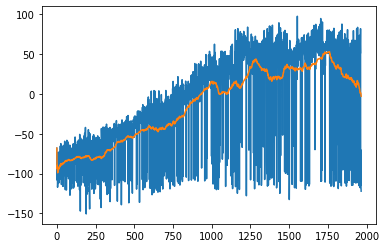

In [10]:
plt.plot(scores)
plt.plot(average_scores)

In [8]:
for episode in range(2):
    state = env.reset()
    score = 0
    input()

    for t in range(1500):
        actions_tensor, log_prob = agent.act(torch.FloatTensor(state).to(device))
        actions = actions_tensor.cpu().data.numpy().flatten()
        next_state, reward, done, _ = env.step(actions_tensor.cpu().numpy())
        
        score += reward
        
        env.render()
        
        if done:
            break;
        
        state = next_state

    print(score)
env.close()


19.841471224294317

23.671279096625117


In [12]:
env.close()